<a href="https://colab.research.google.com/github/IC-UFAL-IADD/IADD/blob/codebasics/%5B2022%5DIADD_FastAI_CNN_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Created by Marcelo Oliveira on 06/2022.
### Disciplina de Fundamentos de IA aplicados ao Diagnóstico de Doenças (IADD).
### Copyright (c)2021 Instituto de Computação
### Universidade Federal de Alagoas - UFAL. All rights reserved.

References:

https://www.kaggle.com/avirdee/siim-covid-19-initial-pipeline-fastai/notebook

In [ ]:
#Instalar antes de Montar Drive
!pip install umap-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!touch "/content/drive/My Drive/ping.txt"

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
!pip install python-gdcm pydicom -q
!pip install kornia -q
!pip install scikit-image -q

In [6]:
import pydicom,kornia,skimage

In [7]:
import pydicom,kornia,skimage
import os
import pandas as pd

In [8]:
from fastbook import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.medical.imaging import *


In [11]:
source=Path("/content/drive/My Drive/DataSets/Classificacao_COVID_NORMAL/")
root="/content/drive/My Drive/DataSets/Classificacao_COVID_NORMAL/"
files = os.listdir(source)
print(files)

['COVID', 'normal', 'models', 'covid_normal.csv']


In [21]:
# A partir do das imagens gera o covid_normal.csv com a imagem(Path) e o label
os.chdir(root)

folders = ['normal', 'COVID']

files = []

for folder in folders:
    for file in os.listdir(folder):
        files.append([folder+'/'+file, folder]). #Files e Target do CSV

pd.DataFrame(files, columns=['files', 'target']).to_csv(root+'covid_normal.csv')

In [22]:
df = pd.read_csv(source/'covid_normal.csv')
df.head()

,Unnamed: 0,files,target
0,0,normal/00e3a7e91a34.dcm,normal
1,1,normal/01a6995ec763.dcm,normal
2,2,normal/01aefe9ed777.dcm,normal
3,3,normal/01b3d67779e8.dcm,normal
4,4,normal/01bf68877dab.dcm,normal


In [23]:
class FixMonochrome(PILDicom):
    @classmethod
    def create(cls, fn:(Path, str, bytes), fix_monochrome = True)->None:
        if isinstance(fn, bytes): im = pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn))
        if isinstance(fn, (Path, str)): im = pydicom.dcmread(fn)
        scaled = np.array(im.pixel_array)   
        if fix_monochrome and im.PhotometricInterpretation == "MONOCHROME1":
            scaled = np.amax(scaled) - scaled
        scaled = scaled - np.min(scaled)
        scaled = scaled / np.max(scaled)
        scaled = (scaled * 255).astype(np.uint8)
        pill_im = Image.fromarray(scaled)
        return cls(pill_im)

In [26]:
ImageBlocks = (ImageBlock(cls=FixMonochrome), CategoryBlock)

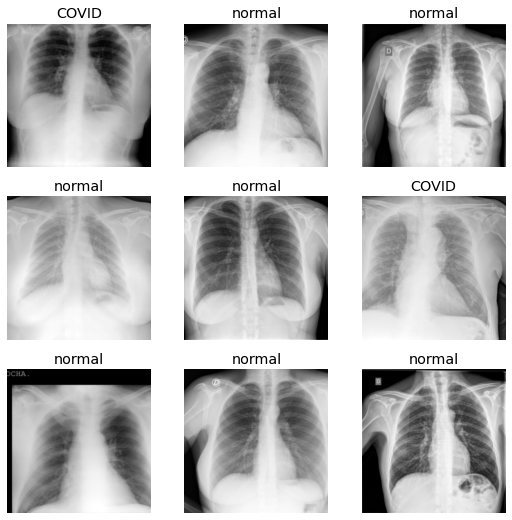

In [28]:
data_block = DataBlock(blocks=ImageBlocks,
                       getters = [ColReader('files', pref=source, suff=''), ColReader('target')],
                       item_tfms = [Resize(224, 224)],
                       splitter  = RandomSplitter(valid_pct=0.2, seed=42)
                      )
#Carregar a Base de Imagens (dataLoader)
dls = data_block.dataloaders(df, bs=16, num_workers=0)  #bs (batch size), workers(processos na RAM, maior o bs maior o workers)
dls.show_batch(max_n=9, ncols=3)

In [ ]:
#https://models.roboflow.com/classification/resnet34
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy, error_rate])

In [ ]:
learn.fine_tune(4)

# Construir o Modelo

In [29]:
#ni: canal de entrada (ou nº de features de entrada)
#nf: features de saída
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [30]:
# Batch Normalization: normalização dos dados para acelerar o treinamento;
def bn(nf): return nn.BatchNorm2d(nf)

In [57]:
def pooling(): return nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

In [50]:
def ReLU(): return nn.ReLU(inplace=False)

In [64]:
# Modelo
modelIADD = nn.Sequential(
    conv(1, 8),
    bn(8),
    ReLU(),
    pooling(),
    conv(8, 16),
    bn(16),
    ReLU(),
    pooling(),
    conv(16,32),
    bn(32),
    ReLU(),
    pooling(),
    conv(32, 16),
    bn(16),
    ReLU(),
    pooling(),
    Flatten()
)

In [65]:
xb, yb = dls.one_batch()

In [66]:
#bs=16, chanel=1, size=224x224
xb.shape

torch.Size([16, 1, 224, 224])

In [67]:
# Total de CLasses
dls.c

2

In [68]:
# No método Learner o Dropout é ativado automaticamente
learn = Learner(
    dls, 
    modelIADD, 
    #loss_func=F.cross_entropy, #funcao para minimizar o erro default
    metrics=[accuracy, error_rate])

In [69]:
learn.summary()

Sequential (Input shape: 16 x 1 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 8 x 112 x 112  
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 8 x 57 x 57    
MaxPool2d                                                      
____________________________________________________________________________
                     16 x 16 x 29 x 29   
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     16 x 16 x 15 x 15   
MaxPool2d                                   

Treinamento usando 4 épocas

In [ ]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.545864,1.958419,0.590164,0.409836,04:36


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.388561,2.089743,0.622951,0.377049,04:29
1,2.286452,1.951958,0.663934,0.336066,04:52
2,2.215824,1.929188,0.655738,0.344262,04:32
3,2.152077,1.886434,0.639344,0.360656,04:26


### Salve o 1 estágio do Modelo para não precisar Retreiná-lo do zero. 

In [ ]:
# Save the model
learn.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
# Load the Model
learn.load('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn) 

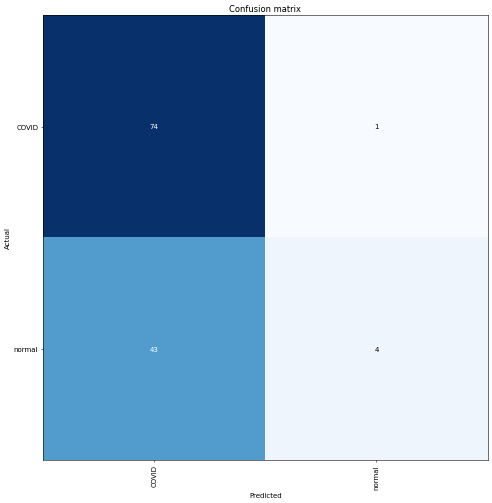

In [ ]:
interp.plot_confusion_matrix(figsize=(15, 10), dpi=50)

In [ ]:
#Parametros da Matriz de Confusão
# Positivo é DOENÇA
upp, low = interp.confusion_matrix()
VP, FN = upp[0], upp[1]
FP, VN = low[0], low[1]

print(VP, FN, FP, VN) #Dica: VP são as pessoas "Verdadeiramente Doentes", VN "Verdadeiramente NÃO Doentes"

74 1 43 4


In [ ]:
#Parametros da Matriz de Confusão
upp, low = interp.confusion_matrix()
VP, FN = upp[0], upp[1]
FP, VN = low[0], low[1]

print(VP, FN, FP, VN) #Dica: VP são as pessoas "Verdadeiramente Doentes", VN "Verdadeiramente NÃO Doentes"

74 1 43 4


### Sensibilidade e Especifidade (Sensitivity and Specificity)

In [ ]:
#Sensibilidade = Verdadeiro Positivo/(Verdadeiro Positivo + False Negativo)
# CAPACIDADE DE DETECTAR DOENÇA
Sensibilidade = VP/(VP + FN)
Sensibilidade


0.9866666666666667

In [ ]:
#Especificidade = Verdadeiro Negativo/(False Positivo + Verdadeiro Negativo
# CAPACIDADE DE ACERTAR CASOS SADIOS

Especificidade = VN/(FP + VN)
Especificidade

0.0851063829787234

### Acuracia: Informa quantos de nossos exemplos foram de fato classificados corretamente, independente da classe. Ex.: Por exemplo, se temos 100 observações e 90 delas foram classificados corretamente, nosso modelo possui uma acurácia de 90%.

Acc = N. de Predições Corretas / N. Total da Base

In [ ]:
preds,y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.6393442749977112 %.


### AUC — Area Under the Curve ou AUROC — Area Under the Receiver Operating Characteristic curve): vantagem desta métrica é que ela não é sensível ao desbalanço de classes, como ocorre com a acurácia.


*   True Positive Rate(TPR) = Sensibilidade = VP/(VP + FN) 
*   False Positive Rate(FPR) = (1- Especificidade) = FP/(VN + FP) 

ref. https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077


In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.6556028368794325


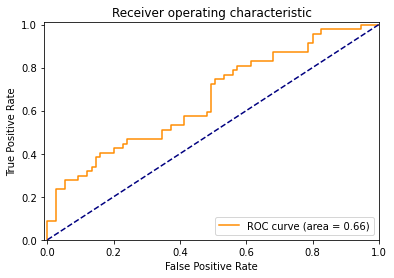

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")